In [1]:
from dataset import BodyMeasurementDataset
from datetime import datetime
from dotenv import load_dotenv
from model import FullModelInCode, FullModelInPaper, FullModel
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision

## Load dataset and model

In [2]:
load_dotenv()

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'
if torch.backends.mps.is_available():
    device = 'mps:0'

dataform_path = os.getenv('DATAFORM_PATH')
train_h5_path = os.path.join(dataform_path, 'train_female.h5')
val_h5_path = os.path.join(dataform_path, 'validate_female.h5')

training_set = BodyMeasurementDataset(train_h5_path)
training_loader = DataLoader(training_set, batch_size=32, shuffle=True)
validate_set = BodyMeasurementDataset(val_h5_path)
validate_loader = DataLoader(validate_set, batch_size=32, shuffle=True)

model = FullModel()

## show samples of dataset

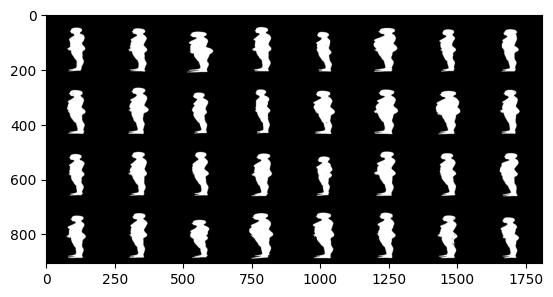

In [3]:
def showimg(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
fronts, sides, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(fronts)
showimg(img_grid)
img_grid = torchvision.utils.make_grid(sides)
showimg(img_grid)

## Train model

In [4]:
def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch_index, tb_writer, write_every=5):
    running_loss = 0.0
    all_loss = 0.0
    
    for i, data in tqdm(enumerate(dataloader)):
        fronts, sides, labels = data
        fronts, sides, labels = fronts.to(device), sides.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(fronts, sides)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        all_loss += running_loss
        if i % write_every == write_every - 1:
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', running_loss, tb_x)
            # print('  epoch: {} batch: {} loss: {}'.format(epoch_index, i, running_loss))
    
    return all_loss / len(dataloader)

def train(model, train_dataloader, validate_dataloader, device, lr=0.001, write_every=10, epochs=150):
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer_path = os.path.join(os.getenv('TENSORBOARD_PATH'), f"model_{timestamp}")
    writer = SummaryWriter(writer_path)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)
    epoch_number = 0
    best_vloss = 1_000_000.

    for epoch in range(epochs):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(model, train_dataloader, optimizer, criterion, 
                                   device, epoch_number, writer)

        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validate_dataloader):
                vfronts, vsides, vlabels = vdata
                vfronts, vsides, vlabels = vfronts.to(device), vsides.to(device), vlabels.to(device)
                voutputs = model(vfronts, vsides)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        ckpt_path = os.path.join(os.getenv('MODEL_CHECKPOINT_PATH'), timestamp)
        if not os.path.exists(ckpt_path):
            os.makedirs(ckpt_path)
        
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), os.path.join(ckpt_path, f"model_{timestamp}_{epoch_number}.ckpt"))

        epoch_number += 1

## Train model (from scratch)

In [5]:
train(model, training_loader, validate_loader, device)

EPOCH 1:


52it [00:03, 17.10it/s]


LOSS train 247471.42286095253 valid 6066.0810546875
EPOCH 2:


52it [00:02, 20.28it/s]


LOSS train 4714.355726975661 valid 3567.069091796875
EPOCH 3:


52it [00:02, 20.26it/s]


LOSS train 3920.1071026141826 valid 2715.399658203125
EPOCH 4:


52it [00:02, 20.14it/s]


LOSS train 3667.175800030048 valid 6888.83349609375
EPOCH 5:


52it [00:02, 20.37it/s]


LOSS train 4144.500361515926 valid 18465.3046875
EPOCH 6:


52it [00:02, 20.30it/s]


LOSS train 5221.227647047776 valid 2719.97216796875
EPOCH 7:


52it [00:02, 20.22it/s]


LOSS train 3250.5201157789966 valid 4641.23583984375
EPOCH 8:


52it [00:02, 20.23it/s]


LOSS train 3460.8451420710635 valid 5490.36328125
EPOCH 9:


52it [00:02, 20.28it/s]


LOSS train 3431.262934758113 valid 5649.07373046875
EPOCH 10:


52it [00:02, 20.29it/s]


LOSS train 4060.6200954730693 valid 2066.907470703125
EPOCH 11:


52it [00:02, 20.15it/s]


LOSS train 2998.8982778695913 valid 5314.583984375
EPOCH 12:


52it [00:02, 20.31it/s]


LOSS train 3560.5496215820312 valid 3906.062255859375
EPOCH 13:


52it [00:02, 20.27it/s]


LOSS train 3881.697002704327 valid 3077.50927734375
EPOCH 14:


52it [00:02, 20.02it/s]


LOSS train 3388.050255408654 valid 4129.162109375
EPOCH 15:


52it [00:02, 20.06it/s]


LOSS train 3165.4111844576323 valid 2446.081787109375
EPOCH 16:


52it [00:02, 20.28it/s]


LOSS train 2972.6494140625 valid 6143.751953125
EPOCH 17:


52it [00:02, 20.12it/s]


LOSS train 3643.055382361779 valid 2567.347900390625
EPOCH 18:


52it [00:02, 20.36it/s]


LOSS train 3647.9795860877402 valid 14347.11328125
EPOCH 19:


52it [00:02, 20.32it/s]


LOSS train 4966.896897536058 valid 4326.74853515625
EPOCH 20:


52it [00:02, 20.38it/s]


LOSS train 3656.5123666616587 valid 3140.959716796875
EPOCH 21:


52it [00:02, 20.34it/s]


LOSS train 3588.0880080003003 valid 3132.8125
EPOCH 22:


52it [00:02, 20.22it/s]


LOSS train 2847.9344717172476 valid 2944.9345703125
EPOCH 23:


52it [00:02, 20.11it/s]


LOSS train 2454.6902547983022 valid 2089.912109375
EPOCH 24:


52it [00:02, 20.31it/s]


LOSS train 2424.2872596153848 valid 1384.3050537109375
EPOCH 25:


52it [00:02, 20.42it/s]


LOSS train 2625.0069415752705 valid 1271.0936279296875
EPOCH 26:


52it [00:02, 20.41it/s]


LOSS train 2271.8662884051982 valid 1293.259521484375
EPOCH 27:


52it [00:02, 20.43it/s]


LOSS train 2570.2302997295674 valid 1358.579833984375
EPOCH 28:


52it [00:02, 20.39it/s]


LOSS train 2931.4855370154746 valid 1428.30615234375
EPOCH 29:


52it [00:02, 20.37it/s]


LOSS train 2360.324439415565 valid 1102.1358642578125
EPOCH 30:


52it [00:02, 20.19it/s]


LOSS train 2263.0314014141377 valid 1298.474853515625
EPOCH 31:


52it [00:02, 20.20it/s]


LOSS train 2075.3751666729268 valid 4964.10498046875
EPOCH 32:


52it [00:02, 20.24it/s]


LOSS train 3032.7772780198316 valid 29033.060546875
EPOCH 33:


52it [00:02, 20.26it/s]


LOSS train 6362.669867882361 valid 5676.48974609375
EPOCH 34:


52it [00:02, 20.31it/s]


LOSS train 2791.5001854529746 valid 1079.3780517578125
EPOCH 35:


52it [00:02, 20.30it/s]


LOSS train 2037.6077974759614 valid 1341.9027099609375
EPOCH 36:


52it [00:02, 20.35it/s]


LOSS train 2049.173805823693 valid 1244.3026123046875
EPOCH 37:


52it [00:02, 20.37it/s]


LOSS train 1997.1910236065205 valid 2227.9609375
EPOCH 38:


52it [00:02, 20.15it/s]


LOSS train 2166.05666410006 valid 1008.947265625
EPOCH 39:


52it [00:02, 20.24it/s]


LOSS train 2274.785069392278 valid 4785.029296875
EPOCH 40:


52it [00:02, 20.27it/s]


LOSS train 2560.434603177584 valid 1173.784423828125
EPOCH 41:


52it [00:02, 20.37it/s]


LOSS train 2016.5900010329026 valid 3782.709716796875
EPOCH 42:


52it [00:02, 20.40it/s]


LOSS train 2193.2442157451924 valid 3841.17529296875
EPOCH 43:


52it [00:02, 20.36it/s]


LOSS train 2221.67651954064 valid 1549.88671875
EPOCH 44:


52it [00:02, 20.36it/s]


LOSS train 2138.189943753756 valid 1595.84521484375
EPOCH 45:


52it [00:02, 20.45it/s]


LOSS train 2126.3675161508413 valid 1253.9462890625
EPOCH 46:


52it [00:02, 20.25it/s]


LOSS train 2158.571958101713 valid 4248.0380859375
EPOCH 47:


52it [00:02, 20.32it/s]


LOSS train 2571.5172259990986 valid 1546.7762451171875
EPOCH 48:


52it [00:02, 20.41it/s]


LOSS train 2551.2014606182393 valid 1410.82666015625
EPOCH 49:


52it [00:02, 20.43it/s]


LOSS train 1997.4756493201623 valid 1058.257080078125
EPOCH 50:


52it [00:02, 20.36it/s]


LOSS train 2115.0382878230166 valid 1150.95458984375
EPOCH 51:


52it [00:02, 20.38it/s]


LOSS train 2266.4805039625903 valid 2298.1162109375
EPOCH 52:


52it [00:02, 20.40it/s]


LOSS train 2545.912845318134 valid 2092.74951171875
EPOCH 53:


52it [00:02, 20.38it/s]


LOSS train 2187.4135225736177 valid 2403.081298828125
EPOCH 54:


52it [00:02, 20.23it/s]


LOSS train 2094.0448232797476 valid 984.3804931640625
EPOCH 55:


52it [00:02, 20.08it/s]


LOSS train 1955.1831265963042 valid 3755.449951171875
EPOCH 56:


52it [00:02, 20.31it/s]


LOSS train 2170.9903165377104 valid 2783.614013671875
EPOCH 57:


52it [00:02, 20.05it/s]


LOSS train 1977.6781334510217 valid 1996.266845703125
EPOCH 58:


52it [00:02, 20.12it/s]


LOSS train 2263.571941669171 valid 2779.66943359375
EPOCH 59:


52it [00:02, 20.25it/s]


LOSS train 2725.6426720252402 valid 1117.395751953125
EPOCH 60:


52it [00:02, 20.15it/s]


LOSS train 1835.889173067533 valid 2276.716552734375
EPOCH 61:


52it [00:02, 20.20it/s]


LOSS train 1922.710193340595 valid 991.47216796875
EPOCH 62:


52it [00:02, 20.30it/s]


LOSS train 1797.1709125225361 valid 2316.8388671875
EPOCH 63:


52it [00:02, 20.32it/s]


LOSS train 2364.8172290508564 valid 1081.2406005859375
EPOCH 64:


52it [00:02, 20.13it/s]


LOSS train 1952.9174335186299 valid 4071.84765625
EPOCH 65:


52it [00:02, 20.13it/s]


LOSS train 1968.2767052283655 valid 1054.8646240234375
EPOCH 66:


52it [00:02, 20.24it/s]


LOSS train 1918.4933495154748 valid 1027.864013671875
EPOCH 67:


52it [00:02, 20.25it/s]


LOSS train 2027.1138258713943 valid 1776.4256591796875
EPOCH 68:


52it [00:02, 20.28it/s]


LOSS train 2234.017315204327 valid 1395.618408203125
EPOCH 69:


52it [00:02, 20.24it/s]


LOSS train 2010.2295720027043 valid 959.2050170898438
EPOCH 70:


52it [00:02, 20.21it/s]


LOSS train 1909.0116647573618 valid 1378.0902099609375
EPOCH 71:


52it [00:02, 20.23it/s]


LOSS train 2078.5084158090444 valid 1453.64892578125
EPOCH 72:


52it [00:02, 20.21it/s]


LOSS train 2151.9707782451924 valid 1624.7642822265625
EPOCH 73:


52it [00:02, 20.43it/s]


LOSS train 1999.8168252798228 valid 2229.65869140625
EPOCH 74:


52it [00:02, 20.45it/s]


LOSS train 2046.8670302170974 valid 990.0864868164062
EPOCH 75:


52it [00:02, 20.39it/s]


LOSS train 1897.3347660945012 valid 1128.11767578125
EPOCH 76:


52it [00:02, 20.43it/s]


LOSS train 2157.037029559796 valid 2125.7314453125
EPOCH 77:


52it [00:02, 20.41it/s]


LOSS train 1996.9833350548377 valid 2457.2509765625
EPOCH 78:


52it [00:02, 20.28it/s]


LOSS train 2257.8030818058896 valid 1162.462158203125
EPOCH 79:


52it [00:02, 20.20it/s]


LOSS train 1824.6568908691406 valid 1823.05078125
EPOCH 80:


52it [00:02, 20.22it/s]


LOSS train 1884.338111290565 valid 1199.7100830078125
EPOCH 81:


52it [00:02, 20.25it/s]


LOSS train 1999.5252990722656 valid 2069.190673828125
EPOCH 82:


52it [00:02, 20.43it/s]


LOSS train 1953.3463880098784 valid 1314.792236328125
EPOCH 83:


52it [00:02, 20.43it/s]


LOSS train 1818.891848050631 valid 951.7037963867188
EPOCH 84:


52it [00:02, 20.33it/s]


LOSS train 1944.7984478290264 valid 3860.589111328125
EPOCH 85:


52it [00:02, 20.21it/s]


LOSS train 2577.8471233661357 valid 998.9188232421875
EPOCH 86:


52it [00:02, 20.13it/s]


LOSS train 2227.5028862586387 valid 3438.71728515625
EPOCH 87:


52it [00:02, 20.29it/s]


LOSS train 2368.7486337515024 valid 8365.2138671875
EPOCH 88:


52it [00:02, 20.23it/s]


LOSS train 3312.6588087815503 valid 1898.0947265625
EPOCH 89:


52it [00:02, 20.00it/s]


LOSS train 1997.9516859788162 valid 1076.8116455078125
EPOCH 90:


52it [00:02, 20.21it/s]


LOSS train 1830.1473975548377 valid 1668.623046875
EPOCH 91:


52it [00:02, 20.26it/s]


LOSS train 2007.604228093074 valid 1480.39404296875
EPOCH 92:


52it [00:02, 20.28it/s]


LOSS train 1936.029033954327 valid 2454.330322265625
EPOCH 93:


52it [00:02, 20.33it/s]


LOSS train 1976.3976088303787 valid 1024.650390625
EPOCH 94:


52it [00:02, 20.25it/s]


LOSS train 2007.5003122182993 valid 965.8223876953125
EPOCH 95:


52it [00:02, 20.25it/s]


LOSS train 1931.3124366173377 valid 1182.293701171875
EPOCH 96:


52it [00:02, 20.22it/s]


LOSS train 2054.2950486403247 valid 1161.278564453125
EPOCH 97:


52it [00:02, 20.22it/s]


LOSS train 1986.3639514629658 valid 2346.168212890625
EPOCH 98:


52it [00:02, 20.07it/s]


LOSS train 1929.3340900127705 valid 4780.2685546875
EPOCH 99:


52it [00:02, 20.33it/s]


LOSS train 2190.2965346116284 valid 2479.4755859375
EPOCH 100:


52it [00:02, 20.39it/s]


LOSS train 1801.501247699444 valid 2788.000732421875
EPOCH 101:


52it [00:02, 20.40it/s]


LOSS train 1736.2496643066406 valid 3184.7177734375
EPOCH 102:


52it [00:02, 20.42it/s]


LOSS train 2063.035337007963 valid 5899.4482421875
EPOCH 103:


52it [00:02, 20.36it/s]


LOSS train 1939.088882446289 valid 1210.572021484375
EPOCH 104:


52it [00:02, 20.37it/s]


LOSS train 1853.473146878756 valid 1181.4058837890625
EPOCH 105:


52it [00:02, 20.22it/s]


LOSS train 1858.4332463191106 valid 1274.6810302734375
EPOCH 106:


52it [00:02, 20.35it/s]


LOSS train 1780.341552734375 valid 7529.04443359375
EPOCH 107:


52it [00:02, 20.41it/s]


LOSS train 2019.3476139948918 valid 1578.336669921875
EPOCH 108:


52it [00:02, 20.43it/s]


LOSS train 1683.1604708158052 valid 1605.0955810546875
EPOCH 109:


52it [00:02, 20.34it/s]


LOSS train 1674.6031752366287 valid 1973.1175537109375
EPOCH 110:


52it [00:02, 20.38it/s]


LOSS train 1633.9207247220552 valid 8188.1484375
EPOCH 111:


52it [00:02, 20.39it/s]


LOSS train 1899.1363877516526 valid 1055.254150390625
EPOCH 112:


52it [00:02, 20.42it/s]


LOSS train 1863.403087909405 valid 3379.832763671875
EPOCH 113:


52it [00:02, 20.42it/s]


LOSS train 1633.7273993858923 valid 2193.73388671875
EPOCH 114:


52it [00:02, 20.41it/s]


LOSS train 1653.5703805776743 valid 10150.2802734375
EPOCH 115:


52it [00:02, 20.42it/s]


LOSS train 1994.884505051833 valid 10115.52734375
EPOCH 116:


52it [00:02, 20.39it/s]


LOSS train 1882.8630112868088 valid 6832.21826171875
EPOCH 117:


52it [00:02, 20.38it/s]


LOSS train 1629.6661353478064 valid 13123.849609375
EPOCH 118:


52it [00:02, 20.38it/s]


LOSS train 1823.849821824294 valid 5541.626953125
EPOCH 119:


52it [00:02, 20.42it/s]


LOSS train 1587.6783423790564 valid 9934.33203125
EPOCH 120:


52it [00:02, 20.33it/s]


LOSS train 1742.7438354492188 valid 3628.23681640625
EPOCH 121:


52it [00:02, 20.36it/s]


LOSS train 1677.938008235051 valid 11112.3916015625
EPOCH 122:


52it [00:02, 20.33it/s]


LOSS train 1519.7591599684495 valid 9027.154296875
EPOCH 123:


52it [00:02, 20.34it/s]


LOSS train 1561.5977196326623 valid 11308.3642578125
EPOCH 124:


52it [00:02, 20.17it/s]


LOSS train 1628.4463377732498 valid 15716.873046875
EPOCH 125:


52it [00:02, 20.10it/s]


LOSS train 1491.4276076096755 valid 13597.0703125
EPOCH 126:


52it [00:02, 20.08it/s]


LOSS train 1536.919452373798 valid 12708.7939453125
EPOCH 127:


52it [00:02, 20.26it/s]


LOSS train 1487.407245342548 valid 13206.1435546875
EPOCH 128:


52it [00:02, 20.21it/s]


LOSS train 1470.6155043381912 valid 9996.208984375
EPOCH 129:


52it [00:02, 20.31it/s]


LOSS train 1480.5492365910457 valid 13518.1982421875
EPOCH 130:


52it [00:02, 20.03it/s]


LOSS train 1369.1713115985576 valid 15544.5546875
EPOCH 131:


52it [00:02, 20.35it/s]


LOSS train 1448.8783510648286 valid 10920.0263671875
EPOCH 132:


52it [00:02, 20.40it/s]


LOSS train 1448.2935016338643 valid 12065.3505859375
EPOCH 133:


52it [00:02, 20.28it/s]


LOSS train 1488.7347412109375 valid 6257.630859375
EPOCH 134:


52it [00:02, 20.21it/s]


LOSS train 1787.8263326791616 valid 11501.6220703125
EPOCH 135:


52it [00:02, 20.07it/s]


LOSS train 1391.9569115271936 valid 18212.828125
EPOCH 136:


52it [00:02, 20.16it/s]


LOSS train 1540.6305225078877 valid 14530.84375
EPOCH 137:


52it [00:02, 20.39it/s]


LOSS train 1395.5170100285457 valid 9204.04296875
EPOCH 138:


52it [00:02, 20.42it/s]


LOSS train 1541.9868774414062 valid 14135.478515625
EPOCH 139:


52it [00:02, 20.42it/s]


LOSS train 1507.4396608792817 valid 11637.0078125
EPOCH 140:


52it [00:02, 20.36it/s]


LOSS train 1422.5487342247595 valid 9537.1962890625
EPOCH 141:


52it [00:02, 20.41it/s]


LOSS train 1472.402816772461 valid 16294.603515625
EPOCH 142:


52it [00:02, 20.33it/s]


LOSS train 1415.794946523813 valid 15724.392578125
EPOCH 143:


52it [00:02, 20.12it/s]


LOSS train 1382.7405172494741 valid 26671.646484375
EPOCH 144:


52it [00:02, 20.17it/s]


LOSS train 1444.599134005033 valid 17621.333984375
EPOCH 145:


52it [00:02, 20.18it/s]


LOSS train 1369.145268366887 valid 9893.9345703125
EPOCH 146:


52it [00:02, 19.98it/s]


LOSS train 1571.7753448486328 valid 19606.888671875
EPOCH 147:


52it [00:02, 20.40it/s]


LOSS train 1454.7525799091045 valid 27002.515625
EPOCH 148:


52it [00:02, 20.27it/s]


LOSS train 1499.4422760009766 valid 15014.4814453125
EPOCH 149:


52it [00:02, 20.34it/s]


LOSS train 1391.9604703463042 valid 13842.376953125
EPOCH 150:


52it [00:02, 20.34it/s]


LOSS train 1600.090552696815 valid 38967.02734375


In [6]:
# train from a checkpoint
model = FullModel()
model.load_state_dict(torch.load('model/model_20231028_220313_138.ckpt'))
train(model, training_loader, validate_loader, device, lr=0.0001, epochs=200)

## Train model replicated from code (from scratch)

## Train model replicated from paper (from scratch)